# Covid-19 Analysis

## Adrian Tasistro-Hart

This notebook uses data compiled by the New York Times to analyze the development of COVID-19 cases in the US.

In [131]:
import numpy as np
from scipy.signal import windows, detrend
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from tqdm import notebook

from spectral import *

Note that the FIPS column in the NYTimes data is the same as the GEOID column in the county geometry data.

In [65]:
# NYTimes data
dat = pd.read_csv('us-counties.csv')

# county GIS data
cnt = gpd.read_file('tl_2017_us_county/tl_2017_us_county.shp')
cnt['GEOID'] = cnt['GEOID'].astype(np.int)
cnt.set_index(cnt['GEOID'], inplace=True)

# county level racial demographic data
race = pd.read_csv('census_race.txt')
# convert to same fips code as in NYTimes data
race.set_index(race['GEOID'].str.split('US', expand=True)[1].astype(np.int), inplace=True)

Now we'll gather other county-level datasets into the county dataframe.

In [66]:
# race
race_cols = ['B02001e1', 'B02001e2', 'B02001e3']
cnt[race_cols] = race[race_cols]

# now get county-scale deaths and cases
cnt_tot_covid = dat.groupby('fips').sum()
# temporary county level dataframe
cnt[list(cnt_tot_covid)] = cnt_tot_covid

## National Cases

In [50]:
tot = dat.groupby('date').sum()[['cases', 'deaths']]
new = tot.diff()

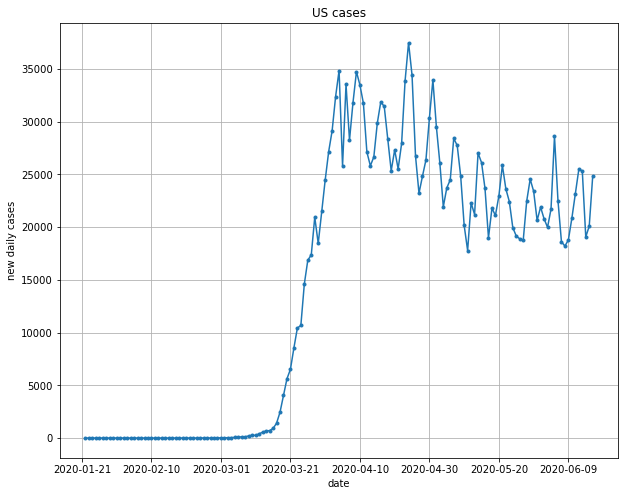

In [51]:
fig = plt.figure(figsize=(10,8))
new['cases'].plot(marker='.')
plt.ylabel('new daily cases')
plt.title('US cases')
plt.grid()
plt.show()

Right off the bat three clear signals in the time series of new daily cases across the US are:
1. A dramatic increase in late March marking the initial spread of the virus
1. A linear decrease to and stabilization of new daily cases around 22,000 (possibly to increase soon with the arrival of a second wave). 
1. A strong weekly cycle in the new case count, with new cases peaking on Fridays of a given week.

I wanted an excuse to implement multi-taper spectral analysis in python, so the following code blocks show the output of `multitaper()` on the above time series, clearly demonstrating the weekly periodicity.

In [134]:
S_est, f = multitaper(detrend(new['cases'].values[1:]), 1, 2)

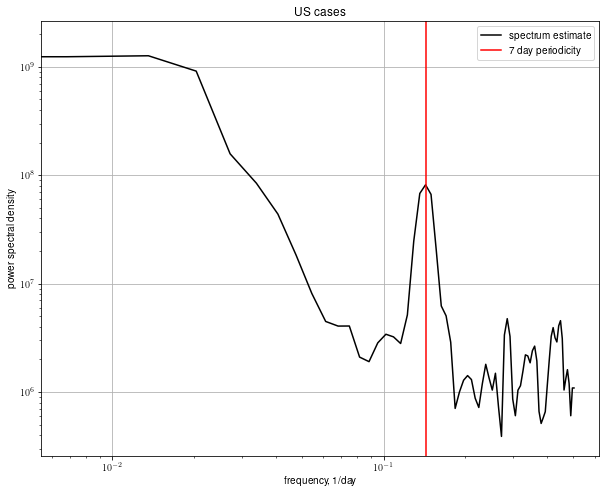

In [135]:
fig = plt.figure(figsize=(10,8))
plt.loglog(f, S_est, 'k')
plt.axvline(1/7, color='r')
plt.xlabel('frequency, 1/day')
plt.ylabel('power spectral density')
plt.title('US cases')
plt.grid()
plt.legend(['spectrum estimate', '7 day periodicity'])
plt.show()

## Specific Counties

In [7]:
idx = np.where((dat['county'] == 'Santa Barbara') & (dat['state'] == 'California'))
oconee = dat.iloc[idx]
oconee.index = pd.DatetimeIndex(oconee['date'])

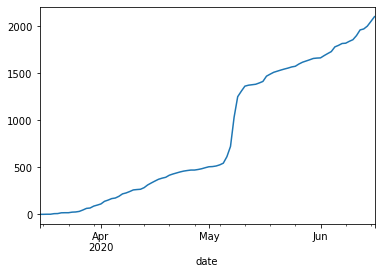

In [8]:
oconee['cases'].plot()
plt.show()

## County-scale recent trends

Now I'll determine for each county the population-scaled trends in daily new case occurrences. First, I'll just consider the mean of the daily new-case rate for each county, which is effectively the velocity of the virus spread in each county (as opposed to the trend in the velocity, which the NYTimes plots and serves as a metric of virus spread acceleration). 

In [91]:
win = 8  # window length in number of days for which to compute the trend
trend_col = '%d day trend' % win
fips = cnt['GEOID'].unique()

cnt_trend = pd.DataFrame(index=fips, columns=[trend_col])
for fip in notebook.tqdm(fips):
    tmp_df = dat[dat['fips'] == fip]
    tmp_df.set_index(pd.DatetimeIndex(tmp_df['date']), inplace=True)
    tmp_df = tmp_df['cases'].diff()
    cnt_trend.loc[fip][trend_col] = tmp_df[tmp_df.index > (pd.to_datetime('today')-pd.Timedelta(win, 'd'))].mean()

In [92]:
# add trend data to temporary county dataframe
cnt[trend_col] = cnt_trend[trend_col].astype(np.float)
# normalize
cnt[trend_col] = cnt[trend_col]/cnt['B02001e1']

## Race vs. Covid-19 

Now I want to see how the racial demographics of counties correlates with the spread of the virus.

In [81]:
# compute fractional quantities
cnt['white frac'] = cnt['B02001e2']/cnt['B02001e1']
cnt['black frac'] = cnt['B02001e3']/cnt['B02001e1']
cnt['death frac'] = cnt['deaths']/cnt['cases']

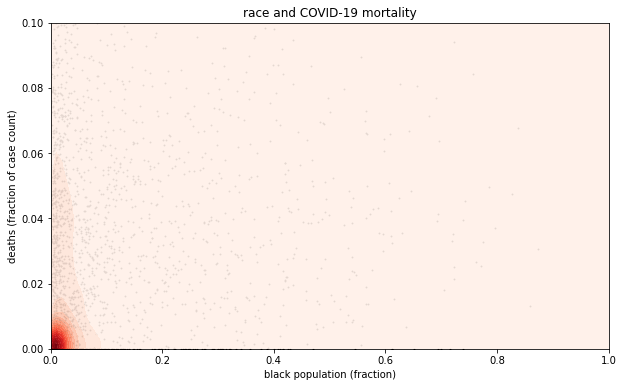

In [86]:
# compute KDE
kde = stats.gaussian_kde(cnt[['black frac', 'death frac']].dropna().values.T, bw_method=0.1)

# evaluate on grid
ymax = 0.1
xmax = 1
X, Y = np.meshgrid(np.linspace(0, xmax, 100), np.linspace(0, ymax, 100))
x = X.reshape(-1)
y = Y.reshape(-1)
f = kde(np.row_stack((x,y)))

# plot with contours
plt.figure(figsize=(10,6))
plt.scatter(cnt['black frac'], cnt['death frac'], s=3, marker='.', color='k')
plt.contourf(X, Y, f.reshape(X.shape), cmap='Reds', alpha=0.9, levels=15)
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.xlabel('black population (fraction)')
plt.ylabel('deaths (fraction of case count)')
plt.title('race and COVID-19 mortality')
plt.show()

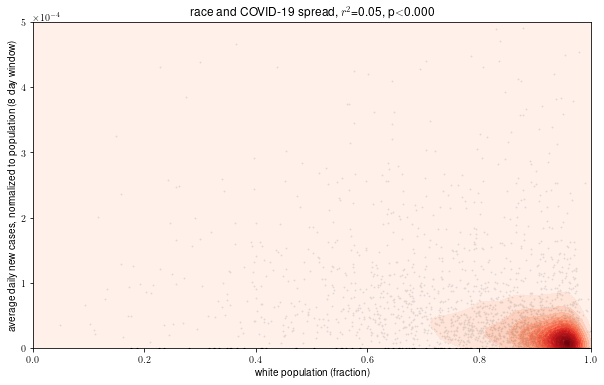

In [133]:
# compute KDE
kde = stats.gaussian_kde(cnt[['white frac', trend_col]].dropna().values.T, bw_method=0.1)

# indices of non nan values
idx = np.logical_not(cnt['white frac'].isna()) & np.logical_not(cnt[trend_col].isna())
# correlation
r, p = stats.pearsonr(cnt[idx]['white frac'], cnt[idx][trend_col])

# least squares line


# evaluate on grid
ymax = 5e-4
xmax = 1
X, Y = np.meshgrid(np.linspace(0, xmax, 100), np.linspace(0, ymax, 100))
x = X.reshape(-1)
y = Y.reshape(-1)
f = kde(np.row_stack((x,y)))

# plot with contours
plt.figure(figsize=(10,6))
plt.scatter(cnt['white frac'], cnt[trend_col], s=3, marker='.', color='k')
plt.contourf(X, Y, f.reshape(X.shape), cmap='Reds', alpha=0.9, levels=15)
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('white population (fraction)')
plt.ylabel('average daily new cases, normalized to population (%d day window)' % win)
plt.title('race and COVID-19 spread, $r^2$=%1.2f, p$<$%1.3f' % (r**2, np.round(p, 3)))
plt.show()